## Setup environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install datasets
!pip install transformers==4.28.0
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space

## import libraries

In [3]:
import os
import numpy as np
import pandas as pd
import torch
import pytesseract

from datasets import Dataset, DatasetDict
from datasets import Features, Sequence, ClassLabel, Value, Array2D

from matplotlib import pyplot as plt

from PIL import Image, ImageDraw, ImageFont

from transformers import Trainer, TrainingArguments
from transformers import LayoutLMTokenizer
from transformers import EarlyStoppingCallback


## Getting the data

In [4]:
label2idx={'resume': 0, 'invoice': 1, 'id': 2, 'receipt': 3}

## Reload preprocessed data

In [5]:
from datasets import load_from_disk

updated_csv = load_from_disk("/content/drive/MyDrive/PFE_Master/data/dict_layouLM__preprocess_cleaned_stop_words")
updated_csv

DatasetDict({
    train: Dataset({
        features: ['image_path', 'label', 'words', 'bbox', '__index_level_0__'],
        num_rows: 1081
    })
    valid: Dataset({
        features: ['image_path', 'label', 'words', 'bbox', '__index_level_0__'],
        num_rows: 232
    })
    test: Dataset({
        features: ['image_path', 'label', 'words', 'bbox', '__index_level_0__'],
        num_rows: 232
    })
})

In [6]:
tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

def encode_example(example, max_seq_length=256, pad_token_box=[0, 0, 0, 0], noise = True, tokenizer=tokenizer):


  if noise==True:
    del example['__index_level_0__']
  words = example['words']
  normalized_word_boxes = example['bbox']


  assert len(words) == len(normalized_word_boxes)

  token_boxes = []
  for word, box in zip(words, normalized_word_boxes):
      word_tokens = tokenizer.tokenize(word)
      token_boxes.extend([box] * len(word_tokens))

  # Truncation of token_boxes
  special_tokens_count = 2
  if len(token_boxes) > max_seq_length - special_tokens_count:
      token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]
  # add bounding boxes of cls + sep tokens
  token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]

  encoding = tokenizer(' '.join(words), max_length=max_seq_length,padding='max_length', truncation=True)
  # Padding of token_boxes up the bounding boxes to the sequence length.
  input_ids = tokenizer(' '.join(words), max_length=max_seq_length, truncation=True)["input_ids"]

  padding_length = max_seq_length - len(input_ids)
  token_boxes += [pad_token_box] * padding_length
  encoding['bbox'] = token_boxes
  if noise == True:
    encoding['label'] = label2idx[example['label']]
 # print(len(encoding['bbox']))

  assert len(encoding['input_ids']) == max_seq_length
  assert len(encoding['attention_mask']) == max_seq_length
  assert len(encoding['token_type_ids']) == max_seq_length
  assert len(encoding['bbox']) == max_seq_length


  return encoding


In [7]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D

labels = list(label2idx.keys())
print(type(labels))
# we need to define the features ourselves as the bbox of LayoutLM are an extra feature
features = Features({
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(256, 4)),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'label': ClassLabel(num_classes=len(labels),names=labels),
    'image_path': Value(dtype='string'),
    'words': Sequence(feature=Value(dtype='string')),
})




encoded_dataset = updated_csv.map(lambda example: encode_example(example),
                                      features=features)


<class 'list'>


In [8]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label', 'image_path', 'words'],
        num_rows: 1081
    })
    valid: Dataset({
        features: ['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label', 'image_path', 'words'],
        num_rows: 232
    })
    test: Dataset({
        features: ['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label', 'image_path', 'words'],
        num_rows: 232
    })
})

In [9]:
df = pd.DataFrame(encoded_dataset["train"])

## Define the model

In [10]:
from transformers import LayoutLMForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMForSequenceClassification.from_pretrained("microsoft/layoutlm-base-uncased",
hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.2,
                                                        num_labels=len(label2idx))
model.to(device)
## 0.4 0.4 ===> 0.7 for 5 epoch
## 0.6 0.25 ===> 0.5 for 5 epoch
## 0.3 0.25 ===> 0.6 for 5 epoch
## 0.5 0.5 ==> 0.4 for 3 epoch
## 0.1 0.1 ==> best

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing LayoutLMForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForSequenceClassification were not initialized from the model checkpoint 

LayoutLMForSequenceClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0-11): 12 x LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True

In [11]:
import evaluate

precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")
accuracy_metric = evaluate.load("accuracy")

In [12]:
def compute_metrics(pred):

    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)

    precision = precision_metric.compute(predictions=predictions, references=labels, average="micro")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="micro")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="micro")
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)

    return {**precision, **recall, **f1, **accuracy,}


## Train the model

In [13]:
training_args = TrainingArguments(
    #report_to = 'wandb',
    output_dir='./results',
    evaluation_strategy='steps',
    save_strategy='steps',
    eval_steps=200,
    save_steps=200,
    save_total_limit=5,
    #warmup_steps=500,
    learning_rate=5e-5,
    weight_decay=0.01,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    #num_train_epochs=2,
    load_best_model_at_end = True,
    #run_name = 'custom_training'            # name of the W&B run
    )

In [14]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [15]:
from transformers import TrainerCallback
from copy import deepcopy

trainer = Trainer(

    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=5)
    ]
)

class CustomCallback(TrainerCallback):

    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer

    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = deepcopy(control)
            self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            return control_copy

trainer.add_callback(CustomCallback(trainer))
train = trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
200,No log,0.116718,0.978448,0.978448,0.978448,0.978448


## Evaluate the model

In [16]:
metrics=trainer.evaluate()
metrics

{'eval_loss': 0.11671780794858932,
 'eval_precision': 0.978448275862069,
 'eval_recall': 0.978448275862069,
 'eval_f1': 0.978448275862069,
 'eval_accuracy': 0.978448275862069,
 'eval_runtime': 3.3951,
 'eval_samples_per_second': 68.334,
 'eval_steps_per_second': 7.069,
 'epoch': 3.0}

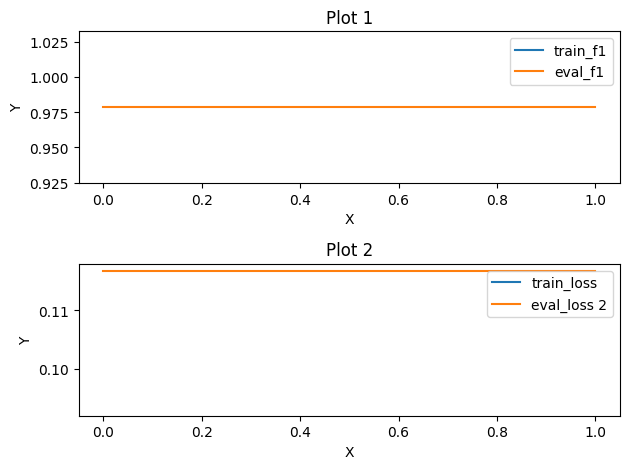

In [17]:
# Assuming 'trainer' is your Trainer instance
train_metrics = trainer.state.log_history
#print(train_metrics[0])
# Accessing a specific metric (e.g., training loss)
#train_accuracy = [metric['train_accuracy'] for metric in train_metrics]
train_f1 = []
eval_f1 = []
train_loss = []
eval_loss = []

for d in train_metrics:
    if 'train_f1' in d:
        train_f1.append(d['train_f1'])
    if 'eval_f1' in d:
        eval_f1.append(d['eval_f1'])
    if 'train_loss' in d:
        train_loss.append(d['train_loss'])
    if 'eval_loss' in d:
        eval_loss.append(d['eval_loss'])


# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2)
x1 = [1, 2, 3]

# Plot lines on the first subplot
ax1.plot(train_f1, label='train_f1')
ax1.plot(eval_f1, label='eval_f1')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Plot 1')
ax1.legend()

# Plot lines on the second subplot
ax2.plot(train_loss, label='train_loss')
ax2.plot(eval_loss, label='eval_loss 2')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Plot 2')
ax2.legend()

# Adjust the layout of the subplots
plt.tight_layout()

# Display the figure
plt.show()

In [18]:
trainer.evaluate(encoded_dataset["test"])

{'eval_loss': 0.027728717774152756,
 'eval_precision': 0.9956896551724138,
 'eval_recall': 0.9956896551724138,
 'eval_f1': 0.9956896551724138,
 'eval_accuracy': 0.9956896551724138,
 'eval_runtime': 3.3227,
 'eval_samples_per_second': 69.823,
 'eval_steps_per_second': 7.223,
 'epoch': 3.0}

In [19]:
trainer.predict(encoded_dataset["test"])

PredictionOutput(predictions=array([[-2.1272488 , -1.7083266 , -2.3062778 ,  5.6608157 ],
       [ 5.989713  , -1.2980727 , -2.1921268 , -1.794447  ],
       [ 6.107707  , -1.6471332 , -1.9510032 , -1.8392797 ],
       [-2.1192129 , -1.811294  , -2.241466  ,  5.6969223 ],
       [-2.223955  , -1.7319419 , -2.238531  ,  5.6685653 ],
       [-1.8074871 ,  5.6924415 , -1.8896828 , -2.3211675 ],
       [-1.6644933 , -2.098664  ,  5.6520967 , -2.0033336 ],
       [-1.7742501 ,  5.745487  , -2.0381742 , -2.254472  ],
       [-2.17898   , -1.8556931 , -2.159109  ,  5.7267904 ],
       [ 6.132516  , -1.6059021 , -2.015623  , -1.7571731 ],
       [ 6.09971   , -1.5943302 , -1.9816588 , -1.8832947 ],
       [ 6.1087375 , -1.4540919 , -2.1295888 , -1.8357671 ],
       [-2.112538  , -2.1904836 , -1.8671294 ,  5.739756  ],
       [-1.6640246 ,  5.712769  , -2.0479412 , -2.2954001 ],
       [-1.9389801 , -2.0044508 ,  5.932893  , -1.8801533 ],
       [-2.015378  , -2.1188443 , -2.0594516 ,  5.748314

In [20]:

# get predictions on test data
preds = trainer.predict(encoded_dataset["test"])

# extract predicted labels
predicted_labels = preds.predictions.argmax(axis=1)
predicted_labels

array([3, 0, 0, 3, 3, 1, 2, 1, 3, 0, 0, 0, 3, 1, 2, 3, 3, 0, 1, 2, 0, 0,
       2, 3, 2, 0, 0, 2, 3, 2, 2, 3, 1, 2, 1, 3, 0, 0, 2, 0, 0, 3, 3, 3,
       2, 0, 3, 2, 1, 0, 0, 3, 0, 2, 0, 0, 3, 0, 1, 0, 3, 3, 1, 2, 2, 2,
       2, 3, 3, 0, 1, 2, 0, 0, 0, 0, 2, 2, 3, 2, 2, 0, 3, 2, 1, 3, 2, 1,
       2, 2, 2, 2, 2, 1, 0, 0, 1, 2, 2, 1, 1, 2, 1, 3, 0, 2, 3, 3, 2, 2,
       3, 0, 3, 3, 0, 2, 1, 3, 0, 2, 0, 2, 1, 0, 2, 1, 3, 3, 2, 2, 1, 3,
       1, 2, 0, 1, 2, 3, 0, 1, 1, 2, 3, 3, 3, 0, 2, 0, 0, 0, 0, 0, 0, 3,
       1, 1, 2, 2, 2, 0, 1, 0, 3, 2, 3, 0, 3, 2, 1, 0, 0, 1, 2, 0, 2, 1,
       3, 2, 2, 2, 3, 3, 0, 2, 3, 1, 2, 3, 1, 2, 1, 2, 3, 0, 0, 3, 1, 3,
       0, 2, 3, 3, 0, 2, 2, 2, 1, 1, 3, 0, 0, 0, 1, 1, 1, 0, 2, 3, 3, 3,
       1, 3, 0, 0, 1, 1, 1, 3, 2, 1, 2, 2])

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

y_pred = list(predicted_labels)
y_true = encoded_dataset["test"]['label']

# Classification report
print(metrics.classification_report(y_true, y_pred,
                                    target_names= ['resume', 'invoice', 'id', 'receipt']))


              precision    recall  f1-score   support

      resume       1.00      1.00      1.00        62
     invoice       1.00      0.98      0.99        46
          id       0.99      1.00      0.99        66
     receipt       1.00      1.00      1.00        58

    accuracy                           1.00       232
   macro avg       1.00      0.99      1.00       232
weighted avg       1.00      1.00      1.00       232



<Axes: >

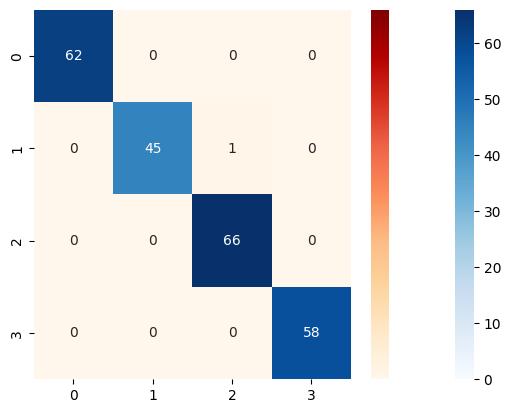

In [22]:
import numpy as np
import seaborn as sns

conf_mat = confusion_matrix(y_true, y_pred)
vmin = np.min(conf_mat)
vmax = np.max(conf_mat)


off_diag_mask = np.eye(*conf_mat.shape, dtype=bool)

fig = plt.figure()
sns.heatmap(conf_mat, annot=True, mask=~off_diag_mask, cmap='Blues',
            vmin=vmin, vmax=vmax)
sns.heatmap(conf_mat, annot=True, mask=off_diag_mask, cmap='OrRd',
            vmin=vmin, vmax=vmax, cbar_kws=dict(ticks=[]))

### Test the model with another dataset

In [23]:
from datasets import load_from_disk

updated_test_dataset = load_from_disk("/content/drive/MyDrive/PFE_Master/data/dict_layouLM_test_images_without_delete_words_test_images_text-20230525T112733Z-001")
updated_test_dataset

DatasetDict({
    test_images: Dataset({
        features: ['image_path', 'label', 'words', 'bbox', '__index_level_0__'],
        num_rows: 18
    })
})

In [24]:
updated_test_dataset["test_images"] = updated_test_dataset["test_images"].remove_columns("__index_level_0__")
